# Railway Track Fault Detection
---
|Subject:|Mathematical Modeling Practice|
|---|---|
|Semester:|Fall 2022|
|Name:|Tamás Demus|
|NEPTUN:|XP4B9D|


## Dataset
---
|Name:|Railway Track Fault Detection|
|---|---|
|Link to dataset:|https://www.kaggle.com/datasets/salmaneunus/railway-track-fault-detection|


## System setup
---
Importing modules

In [1]:
import os
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import cv2 as cv

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from tqdm import tqdm


2022-12-20 02:17:08.228899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 02:17:10.373957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/demust/py39/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-20 02:17:10.374136: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-20 02:17:19.883266: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror:

Setting up environment

In [2]:
raw_folder = './raw/'
data_folder = './data/'
preprocessed_folder = './preprocessed/'
augmented_folder = './augmented/'

PATH = [
    'Train/Non defective/',
    'Train/Defective/',
    'Validation/Non defective/',
    'Validation/Defective/',
    'Test/Non defective/',
    'Test/Defective/',
]

RAW_PATH = [os.path.join(raw_folder, p) for p in PATH]
DATA_PATH = [os.path.join(data_folder, p) for p in PATH]
PREPROCESSED_PATH = [os.path.join(preprocessed_folder, p) for p in PATH]
AUGMENTED_PATH = [os.path.join(augmented_folder, p) for p in PATH[:2]]

for p in DATA_PATH:
    if not os.path.exists(p):
        os.makedirs(p)
        
for p in PREPROCESSED_PATH:
    if not os.path.exists(p):
        os.makedirs(p)
        
for p in AUGMENTED_PATH:
    if not os.path.exists(p):
        os.makedirs(p)

## Raw data
---
File types

In [3]:
ext = []

for p in RAW_PATH:
    for f in os.listdir(p):
        ext.append(os.path.splitext(f)[-1])
    
print(set(ext))

{'.jpg', '.jpeg', '.webp'}


Copy raw dataset with new filenames and converting the extensions

In [4]:
i = 0
p_new = 0
for p in RAW_PATH:
    for f in tqdm(os.listdir(p), desc=p):
        dst = os.path.join(DATA_PATH[p_new], str(i)+'.jpg')
        if not os.path.exists(dst):
            src = os.path.join(p, f)
            img = cv.imread(src)
            cv.imwrite(dst, img)
        i += 1
    p_new += 1


./raw/Test/Defective/: 100%|██████████| 11/11 [00:00<00:00, 63462.65it/s]


## Clean data
---
Create image dataframe

In [3]:
images = pd.DataFrame({
    'type': pd.Series(dtype='str'),
    'defect': pd.Series(dtype='int'),
    'defect_str': pd.Series(dtype='str'),
    'path': pd.Series(dtype='str'),
    'filename': pd.Series(dtype='str'),
    'img': pd.Series(dtype='str'),
    'height': pd.Series(dtype='int'),
    'width': pd.Series(dtype='int'),
    'components': pd.Series(dtype='int'),
    'R_mean': pd.Series(dtype='float'),
    'G_mean': pd.Series(dtype='float'),
    'B_mean': pd.Series(dtype='float')
})

for each in DATA_PATH:
    p = each.split('/')
    if p[3] == 'Defective':
        y = 1
    else:
        y = 0
    for img in os.listdir(each):
        data = {
            'type': p[2].lower(),
            'defect': y,
            'defect_str': p[3],
            'path': each,
            'filename': img,
            'img': os.path.join(each, img),
            'height': 0,
            'width': 0,
            'components': 0,
            'R_mean': 0,
            'G_mean': 0,
            'B_mean': 0
        }
        df = pd.DataFrame(data=data, index=[1])
        images = pd.concat([images, df])

images.reset_index(inplace=True, drop=True)
display(images)
images.info()

type  defect     defect_str                         path filename  \
0    train       0  Non defective  ./data/Train/Non defective/   97.jpg   
1    train       0  Non defective  ./data/Train/Non defective/   79.jpg   
2    train       0  Non defective  ./data/Train/Non defective/  114.jpg   
3    train       0  Non defective  ./data/Train/Non defective/   18.jpg   
4    train       0  Non defective  ./data/Train/Non defective/   46.jpg   
..     ...     ...            ...                          ...      ...   
379   test       1      Defective       ./data/Test/Defective/  381.jpg   
380   test       1      Defective       ./data/Test/Defective/  379.jpg   
381   test       1      Defective       ./data/Test/Defective/  377.jpg   
382   test       1      Defective       ./data/Test/Defective/  380.jpg   
383   test       1      Defective       ./data/Test/Defective/  375.jpg   

                                    img  height  width  components  R_mean  \
0     ./data/Train/Non defective/97.jpg       0      0           0     0.0   
1     ./data/Train/Non defective/79.jpg       0      0           0     0.0   
2    ./data/Train/Non defective/114.jpg       0      0           0     0.0   
3     ./data/Train/Non defective/18.jpg       0      0           0     0.0   
4     ./data/Train/Non defective/46.jpg       0      0           0     0.0   
..                                  ...     ...    ...         ...     ...   
379       ./data/Test/Defective/381.jpg       0      0           0     0.0   
380       ./data/Test/Defective/379.jpg       0      0           0     0.0   
381       ./data/Test/Defective/377.jpg       0      0           0     0.0   
382       ./data/Test/Defective/380.jpg       0      0           0     0.0   
383       ./data/Test/Defective/375.jpg       0      0           0     0.0   

     G_mean  B_mean  
0       0.0     0.0  
1       0.0     0.0  
2       0.0     0.0  
3       0.0     0.0  
4       0.0     0.0  
..      ...     ...  
379     0.0     0.0  
380     0.0     0.0  
381     0.0     0.0  
382     0.0     0.0  
383     0.0     0.0  

[384 rows x 12 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        384 non-null    object 
 1   defect      384 non-null    int64  
 2   defect_str  384 non-null    object 
 3   path        384 non-null    object 
 4   filename    384 non-null    object 
 5   img         384 non-null    object 
 6   height      384 non-null    int64  
 7   width       384 non-null    int64  
 8   components  384 non-null    int64  
 9   R_mean      384 non-null    float64
 10  G_mean      384 non-null    float64
 11  B_mean      384 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 36.1+ KB


## Data exploration
---
Extract basic features from the images

In [6]:
height = []
width = []
components = []
R_mean = []
G_mean = []
B_mean = []

for i in tqdm(images.index):
    image = cv.imread(images.iloc[i].img)
    height.append(image.shape[0])
    width.append(image.shape[1])
    components.append(image.shape[2])
    R_mean.append(np.mean(image[:,:,0]))
    G_mean.append(np.mean(image[:,:,1]))
    B_mean.append(np.mean(image[:,:,2]))

images.update({'height': height})
images.update({'width': width})
images.update({'components': components})
images.update({'R_mean': R_mean})
images.update({'G_mean': G_mean})
images.update({'B_mean': B_mean})

100%|██████████| 384/384 [03:16<00:00,  1.95it/s]


Shape of the images

Minimum  height  :  148  @  243
Maximum  height  :  8000  @  241
Minimum  width  :  156  @  297
Maximum  width  :  8000  @  152
Minimum  components  :  3  @  0
Maximum  components  :  3  @  0
Minimum sizes:
height    322
width     156
Name: 297, dtype: int64
height    148
width     194
Name: 243, dtype: int64


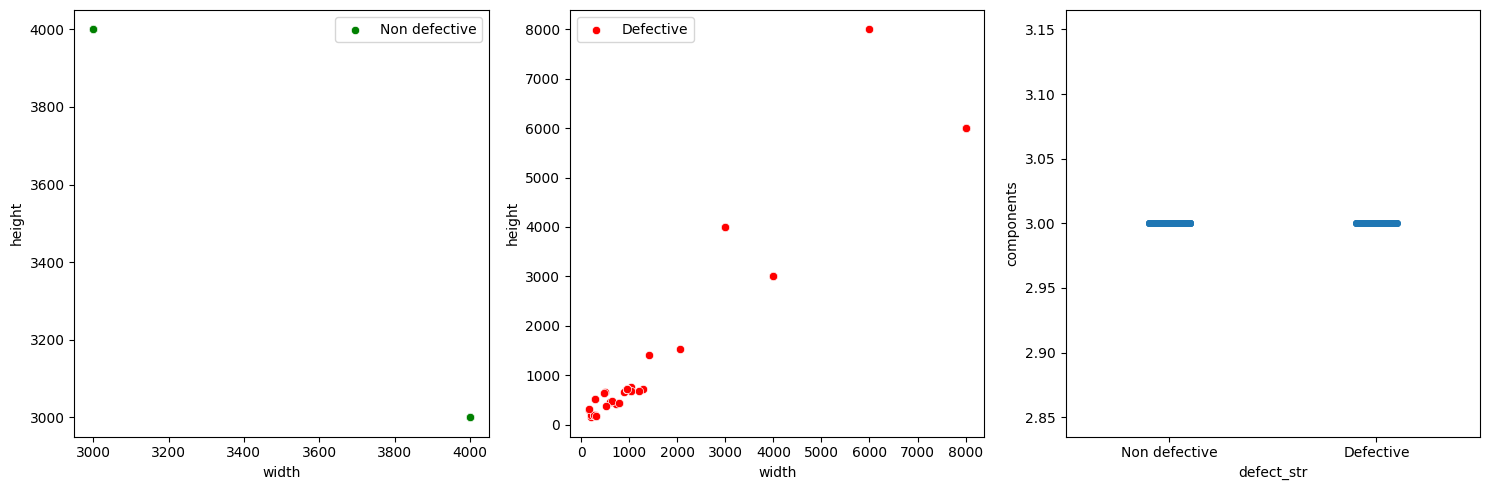

In [7]:
dims = ['height', 'width', 'components']
for dim in dims:
    print('Minimum ', dim, ' : ', images[dim].min(), ' @ ', images[dim].argmin())
    print('Maximum ', dim, ' : ', images[dim].max(), ' @ ', images[dim].argmax())

min_height = np.argmin(images.height)
min_width = np.argmin(images.width)
print('Minimum sizes:')
print(images[['height', 'width']].iloc[min_width])
print(images[['height', 'width']].iloc[min_height])

fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
sns.scatterplot(x='width', y='height', data=images[images.defect == 0], ax=ax[0], label='Non defective', color='green')
sns.scatterplot(x='width', y='height', data=images[images.defect == 1], ax=ax[1], label='Defective', color='red')
sns.stripplot(x='defect_str', y='components', data=images, ax=ax[2])
plt.show()

Main component distribution of the images

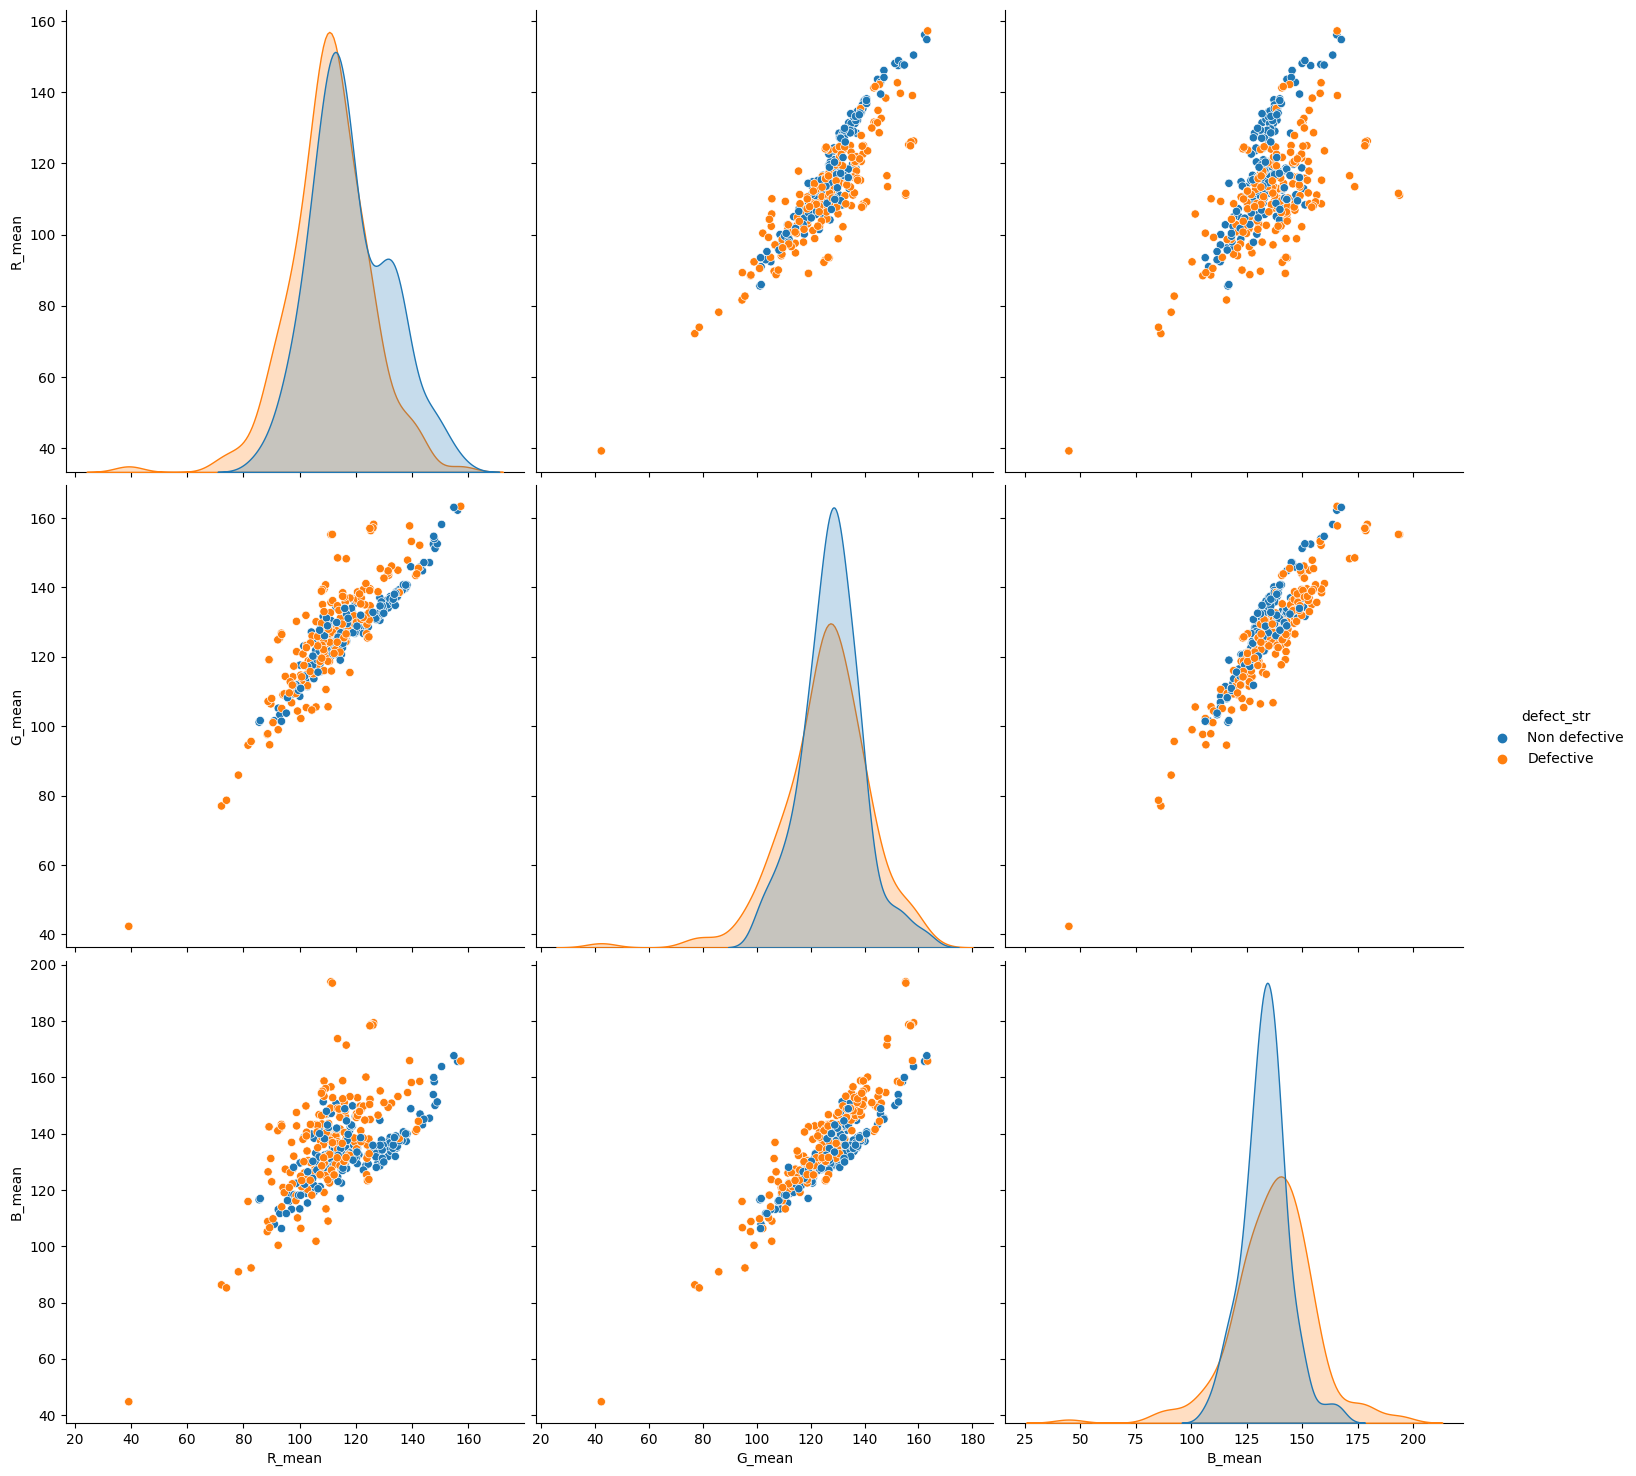

In [8]:
cols = ['R_mean', 'G_mean', 'B_mean']
sns.pairplot(data=images, vars=cols, hue='defect_str', height=5)
plt.show()

Dataset balance

In [9]:
images.groupby(['type', 'defect_str']).count()

defect  path  filename  img  height  width  \
type       defect_str                                                  
test       Defective          11    11        11   11      11     11   
           Non defective      11    11        11   11      11     11   
train      Defective         150   150       150  150     150    150   
           Non defective     150   150       150  150     150    150   
validation Defective          31    31        31   31      31     31   
           Non defective      31    31        31   31      31     31   

                          components  R_mean  G_mean  B_mean  
type       defect_str                                         
test       Defective              11      11      11      11  
           Non defective          11      11      11      11  
train      Defective             150     150     150     150  
           Non defective         150     150     150     150  
validation Defective              31      31      31      31  
           Non defective          31      31      31      31

Generate random sample from training data

In [10]:
N_samples = 2
random_sample_idx = []
for i in range(N_samples):
    idx = np.random.choice(images[(images.type == 'train') & (images.defect == 0)].index)
    random_sample_idx.append(idx)
for i in range(N_samples, 2*N_samples):
    idx = np.random.choice(images[(images.type == 'train') & (images.defect == 1)].index)
    random_sample_idx.append(idx)
random_sample = images.iloc[random_sample_idx].copy()
random_sample

type  defect     defect_str                         path filename  \
34   train       0  Non defective  ./data/Train/Non defective/   69.jpg   
108  train       0  Non defective  ./data/Train/Non defective/   64.jpg   
203  train       1      Defective      ./data/Train/Defective/  287.jpg   
196  train       1      Defective      ./data/Train/Defective/  218.jpg   

                                   img  height  width  components  R_mean  \
34   ./data/Train/Non defective/69.jpg       0      0           0     0.0   
108  ./data/Train/Non defective/64.jpg       0      0           0     0.0   
203     ./data/Train/Defective/287.jpg       0      0           0     0.0   
196     ./data/Train/Defective/218.jpg       0      0           0     0.0   

     G_mean  B_mean  
34      0.0     0.0  
108     0.0     0.0  
203     0.0     0.0  
196     0.0     0.0

Visualize random sample

100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


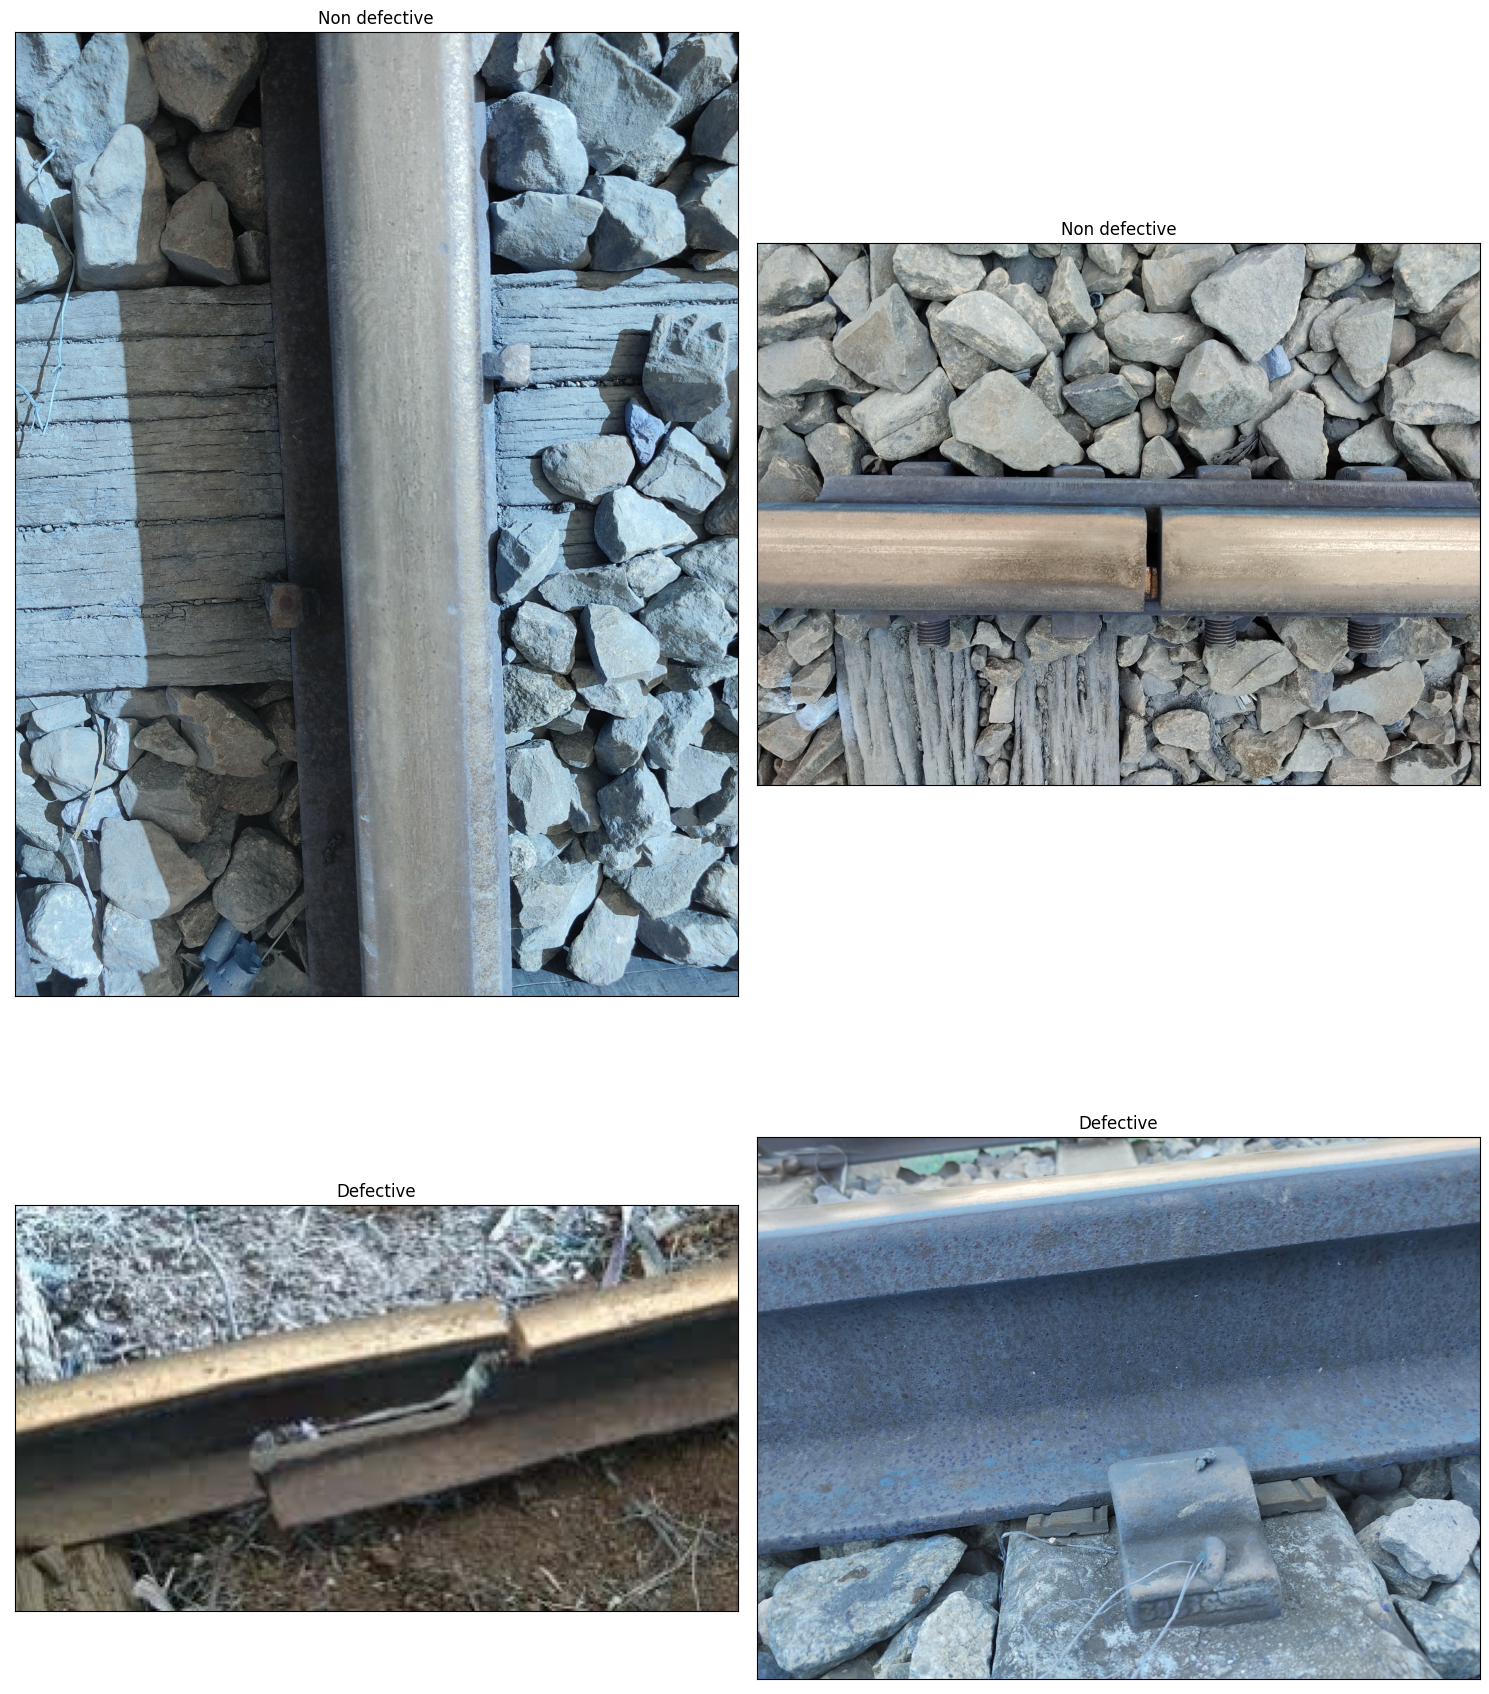

In [11]:
fig, ax = plt.subplots(N_samples, 2, figsize=(15, 10*N_samples), tight_layout=True)
ax = ax.flatten()

for i, idx in enumerate(tqdm(random_sample.index)):
    image = cv.imread(images.img[idx])
    ax[i].imshow(image)
    ax[i].set_xticks(ticks=[])
    ax[i].set_yticks(ticks=[])
    ax[i].set_title(images.defect_str[idx])

plt.show()

Basic information on random sample: color components on RGB and HSV

4it [00:10,  2.59s/it]


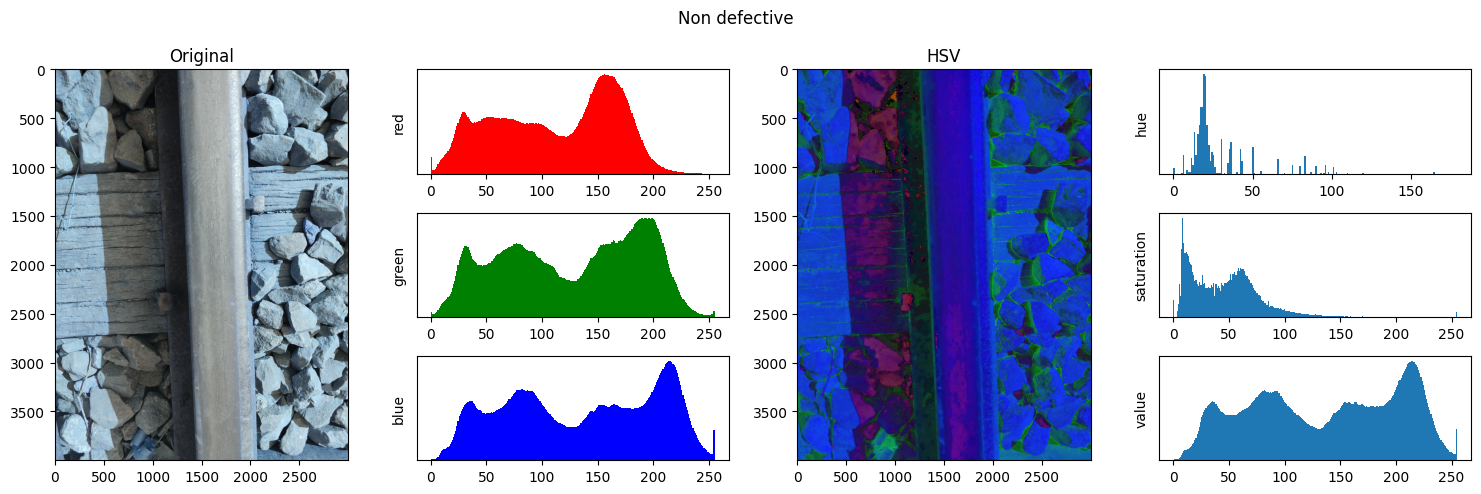

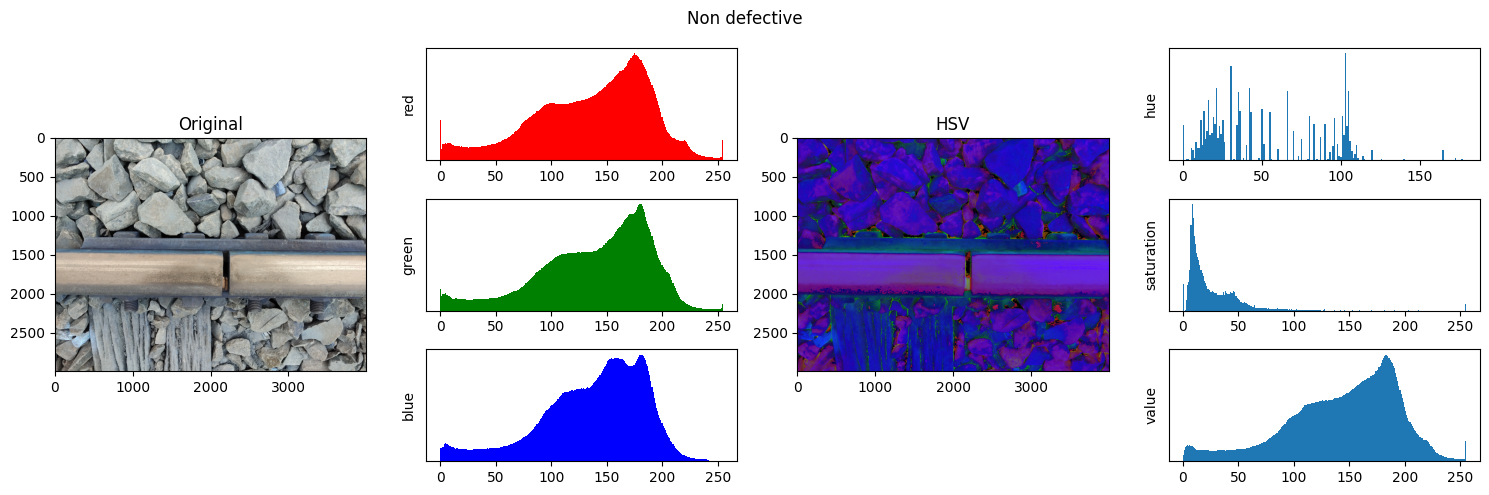

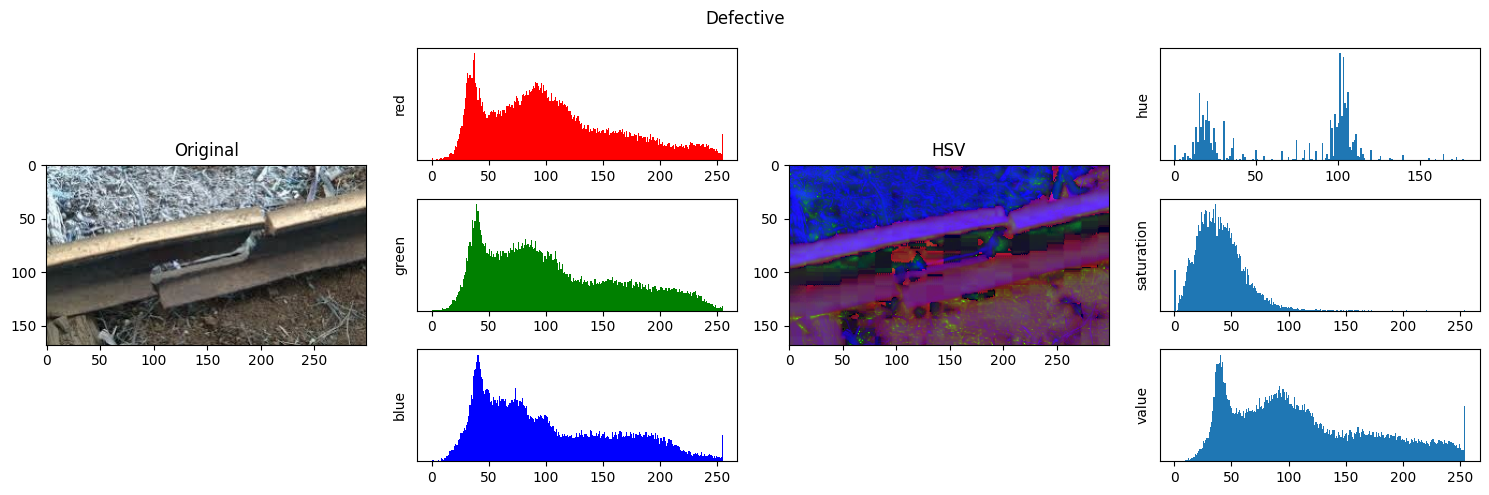

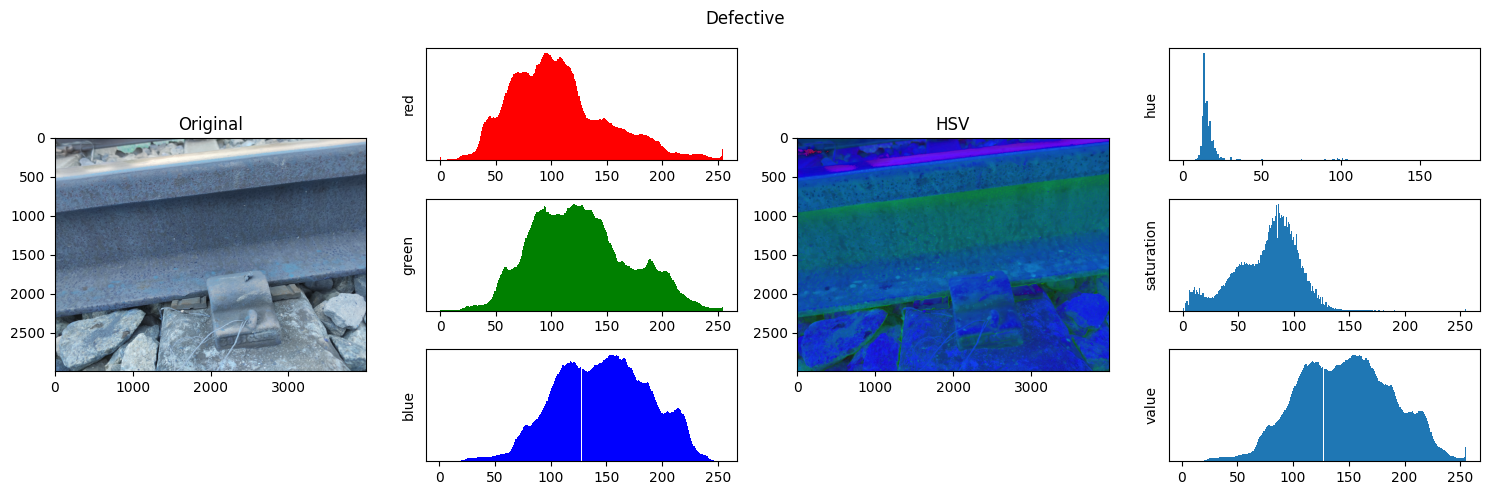

In [25]:
gs = gridspec.GridSpec(3, 4)

for sample in tqdm(random_sample[['img', 'defect_str']].itertuples()):
    fig = plt.figure(figsize=(15, 5), tight_layout=True)
    fig.suptitle(sample.defect_str)
    ax = [
        fig.add_subplot(gs[:, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2, 1]),
        fig.add_subplot(gs[:, 2]),
        fig.add_subplot(gs[0, 3]),
        fig.add_subplot(gs[1, 3]),
        fig.add_subplot(gs[2, 3]),
    ]
    image = cv.imread(sample.img)
    ax[0].imshow(image)
    ax[0].set_title('Original')
    
    for c, component in enumerate(['red', 'green', 'blue']):
        ax[c+1].hist(image[:, :, c].ravel(), bins=256, color=component)
        ax[c+1].set_ylabel(component)
        ax[c+1].set_yticks([])
        
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    ax[4].imshow(hsv)
    ax[4].set_title('HSV')
    
    for c, component in enumerate(['hue', 'saturation', 'value']):
        bins = [180, 256, 256]
        ax[c+5].hist(hsv[:, :, c].ravel(), bins=bins[c])
        ax[c+5].set_ylabel(component)
        ax[c+5].set_yticks([])

## Toolkit
---
Base class

In [4]:
class BaseClass:
    @staticmethod
    def __del__():
        gc.collect()  
        
    @staticmethod
    def remove_old_data(folder):
        for root, _, files in os.walk(folder, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))

Class for image processing

In [5]:
class ImageProcessor(BaseClass):
    def __init__(self, sample):
        self.imgs = [cv.imread(sample.img)]
        self.step = ['original']
        self.plot_kwargs = [{}]
        self.lines = []
        self.function = {
            'resize': self.resize,
            'grayscale': self.grayscale,
            'binary': self.binary,
            'hist_eq': self.hist_eq,
            'noise_filt': self.noise_filt,
            'stretching': self.stretching,
            'Laplacian': self.Laplacian,
            'Canny': self.Canny,
            'Hough': self.Hough,
            'show': self.show
        }
        self.kwargs = {
            'resize': {
                'height': 128,
                'width': 128
            },
            'noise_filt': {
                'type': 'median',
                'size': 1
            },
            'Laplacian': {
                'size': 5
            },
            'Canny': {
                'low': 100,
                'high': 200
            }
        }
    
    def resize(self):
        h, w = self.imgs[-1].shape[:2]
        new_h = self.kwargs.get('resize').get('height')
        new_w = self.kwargs.get('resize').get('width')
        if w < h:
            nh = int(w/h * new_h)
            nw = new_w
            self.imgs.append(
                cv.resize(self.imgs[-1], (nh, nw), interpolation=cv.INTER_AREA)
            )
            pad = int((nh - new_h) / 2)
            if pad > 0:
                self.imgs[-1] = self.imgs[-1][:, pad:-pad]
        else:
            nh = new_h
            nw = int(h/w * new_w)
            self.imgs.append(
                cv.resize(self.imgs[-1], (nh, nw), interpolation=cv.INTER_AREA)
            )
            pad = int((nw - new_w) / 2)
            if pad > 0:
                self.imgs[-1] = self.imgs[-1][pad:-pad, :]
        self.step.append('resize')
        self.plot_kwargs.append({})

    def grayscale(self):
        self.imgs.append(
            cv.cvtColor(self.imgs[-1], cv.COLOR_BGR2GRAY)
        )
        self.step.append('grayscale')
        self.plot_kwargs.append({'cmap': 'gray'})
    
    def binary(self):
        self.imgs.append(
            cv.threshold(self.imgs[-1], 127, 255, cv.THRESH_BINARY)[1]
        )
        self.step.append('binary')
        self.plot_kwargs.append({'cmap': 'gray'})
        
    def hist_eq(self):
        self.imgs.append(
            cv.equalizeHist(self.imgs[-1])
        )
        self.step.append('histogram equalization')
        self.plot_kwargs.append({'cmap': 'gray'})
        
    def noise_filt(self):
        filt_type = self.kwargs.get('noise_filt').get('type')
        filt_size = self.kwargs.get('noise_filt').get('size')
        if filt_type == 'Gaussian':
            self.imgs.append(
                cv.GaussianBlur(self.imgs[-1], filt_size, 0)
            )
        elif filt_type == 'median':
            self.imgs.append(
                cv.medianBlur(self.imgs[-1], filt_size)
            )
        else:
            self.imgs.append(self.imgas[-1])
        self.step.append('noise filter')
        self.plot_kwargs.append({'cmap': 'gray'})
        
    def stretching(self):
        self.imgs.append(
            cv.normalize(self.imgs[-1], None, 0, 1)
        )
        self.step.append('stretch')
        self.plot_kwargs.append({'cmap': 'gray'})
        
    def Laplacian(self):
        size = self.kwargs.get('Laplacian').get('size')
        self.imgs.append(
            np.uint(np.absolute(cv.Laplacian(self.imgs[-1], ddepth=cv.CV_64F, ksize=size)))
        )
        self.step.append('Laplacian')
        self.plot_kwargs.append({'cmap': 'gray'})
    
    def Canny(self):
        low = self.kwargs.get('Canny').get('low')
        high = self.kwargs.get('Canny').get('high')
        self.imgs.append(
            cv.Canny(self.imgs[-1], low, high)
        )
        self.step.append('Canny')
        self.plot_kwargs.append({'cmap': 'gray'})
        
    def Hough(self):
        self.imgs.append(
            self.imgs[-1]
        )
        self.lines = cv.HoughLinesP(self.imgs[-1], 1, np.pi/180, 10, minLineLength=20, maxLineGap=5)
        self.step.append('Hough')
        self.plot_kwargs.append({'cmap': 'gray'})
        
    def show(self):
        _, ax = plt.subplots(1, len(self.imgs), figsize=(15, 5), tight_layout=True)
        for i, img in enumerate(self.imgs):
            ax[i].imshow(img, **self.plot_kwargs[i])
            ax[i].set_xticks(ticks=[])
            ax[i].set_yticks(ticks=[])
            ax[i].set_title(self.step[i])
            if self.step[i] == 'Hough':
                for line in self.lines:
                    x1, y1, x2, y2 = line[0]
                    x = np.linspace(x1, x2, 100, endpoint=True)
                    y = np.linspace(y1, y2, 100, endpoint=True)
                    ax[i].plot(x, y, c='green')
        ax[0].set_ylabel(sample.defect_str)
        plt.show()

Class for data augmentation

In [6]:
class Augmenter(BaseClass):
    def __init__(self, N, df_images):
        self.N = N
        self.images = df_images[df_images.type == 'train']
        self.augmented_images = pd.DataFrame({
            'type': pd.Series(dtype='str'),
            'defect': pd.Series(dtype='int'),
            'defect_str': pd.Series(dtype='str'),
            'path': pd.Series(dtype='str'),
            'filename': pd.Series(dtype='str'),
            'img': pd.Series(dtype='str'),
            'height': pd.Series(dtype='int'),
            'width': pd.Series(dtype='int'),
            'components': pd.Series(dtype='int'),
            'R_mean': pd.Series(dtype='float'),
            'G_mean': pd.Series(dtype='float'),
            'B_mean': pd.Series(dtype='float')
        })
        self.augment_functions = [self.flip, self.random_rotate, self.random_zoom]

    @staticmethod        
    def flip(img):
        img = cv.flip(img, 1)
        return img
    
    @staticmethod
    def random_rotate(img, max_angle=90):
        angle = np.random.uniform(low=-max_angle, high=max_angle)
        h, w = img.shape[:2]
        rotation_matrix = cv.getRotationMatrix2D((h/2.0, w/2.0), angle=angle, scale=1)
        img = cv.warpAffine(img, rotation_matrix, (w, h))
        return img
    
    @staticmethod
    def random_zoom(img, min_factor=0.5, max_factor=1.5):
        zoom_factor = np.random.uniform(low=min_factor, high=max_factor)
        img= cv.resize(img, None, fx=zoom_factor, fy=zoom_factor)
        return img
    
    def select_random_images(self, class_type):
        img_path_list = np.random.choice(self.images.img[images.defect == class_type], self.N, replace=False)
        return img_path_list
    
    def apply_random_function(self, img):
        rand_func = np.random.choice(self.augment_functions)
        img = rand_func(img)
        return img
    
    @staticmethod
    def save_image(img, img_path):
        img_path = img_path.split('/')
        img_path[1] = augmented_folder
        path = os.path.join(*img_path[1:-1])
        filename = img_path[-1].split('.')
        filename = ''.join([filename[0], '_augmented.', filename[1]])
        img_path = os.path.join(path, filename)
        
        cv.imwrite(img_path, img)
        return img_path
    
    def update_df(self, img, img_path):
        img_path = img_path.split('/')
        t = img_path[2].lower()
        defect_str = img_path[3]
        path = os.path.join(*img_path[:-1])
        filename = img_path[-1]
        img_path = os.path.join(path, filename)
        data = {
            'type': t,
            'defect': y,
            'defect_str': defect_str,
            'path': path,
            'filename': filename,
            'img': img_path,
            'height': img.shape[0],
            'width': img.shape[1],
            'components': img.shape[2],
            'R_mean': np.mean(img[:,:,0]),
            'G_mean': np.mean(img[:,:,1]),
            'B_mean': np.mean(img[:,:,2])
        }
        df = pd.DataFrame(data=data, index=[1])
        self.augmented_images = pd.concat([self.augmented_images, df])
        self.augmented_images.reset_index(inplace=True, drop=True)
            
    def augment_images(self):
        for cl in set(self.images.defect):
            img_path_list = self.select_random_images(cl)
            for img_path in img_path_list:
                img = cv.imread(img_path)
                img = self.apply_random_function(img)
                img_path_new = self.save_image(img, img_path)
                self.update_df(img, img_path_new)

Class for Neural Network Model

In [10]:
class Model(BaseClass):
    def __init__(self):
        self.img_steps = ['original']
        self.img_kwargs = {}
        self.height = None
        self.width = None
        self.model = None
        self.data = {}
        self.class_names = None
        self.history = None
        self.predictions = None
        self.score = None
        self.y_pred = None
        self.y_true = None
        self.epochs = 10
        self.batch_size = 32
        
    def image_processor(self, iterator):
        for sample in tqdm(iterator):
            path = sample.img.split('/')
            path[1] = preprocessed_folder
            dst = os.path.join(*path[1:])
            
            obj = ImageProcessor(sample)
            obj.steps = self.img_steps
            obj.kwargs.update(self.img_kwargs)
            
            for step in self.img_steps:
                obj.function.get(step)
        
            cv.imwrite(dst, obj.imgs[-1])
            del obj

    def setup_neural_net(self):   
        datasets = ['Train', 'Validation', 'Test']
        
        try:
            self.height = self.img_kwargs.get('resize').get('height')
            self.width = self.img_kwargs.get('resize').get('width')
        except KeyError:
            self.height = 128
            self.width = 128
        
        for dataset in datasets:
            self.data.update({
                dataset: tf.keras.utils.image_dataset_from_directory(
                    os.path.join(preprocessed_folder, dataset),
                    labels='inferred',
                    image_size=(self.height, self.width), 
                    color_mode='grayscale',
                    batch_size=self.batch_size
                )
            })
        self.class_names = self.data['Train'].class_names
            
        self.model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

        AUTOTUNE = tf.data.AUTOTUNE

        train_ds = self.data['Train'].cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
        val_ds = self.data['Validation'].cache().prefetch(buffer_size=AUTOTUNE)

    def train_net(self):
        self.history = self.model.fit(
            self.data['Train'],
            validation_data=self.data['Validation'],
            epochs=self.epochs
        )
        
    def predict_test(self):
        self.predictions = self.model.predict(self.data['Test'])
        self.score = tf.nn.softmax(self.predictions)
        self.y_pred = np.argmax(self.predictions, axis=1)
        self.y_true = np.array(list(self.data['Test'].take(-1))[-1][-1])
        print('Test values:         ', self.y_true)
        print('Predicted values:    ', self.y_pred)
        
    def show_metrics(self):
        fig, ax = plt.subplots(2, 2, figsize=(15, 10), tight_layout=True)
        sns.lineplot(x=np.arange(self.epochs), y='accuracy', data=self.history.history, ax=ax[0, 0], label='training')
        sns.lineplot(x=np.arange(self.epochs), y='val_accuracy', data=self.history.history, ax=ax[0, 0], label='validation')
        sns.lineplot(x=np.arange(self.epochs), y='loss', data=self.history.history, ax=ax[0, 1], label='training')
        sns.lineplot(x=np.arange(self.epochs), y='val_loss', data=self.history.history, ax=ax[0, 1], label='validation')
        ConfusionMatrixDisplay.from_predictions(self.y_true, self.y_pred, display_labels=self.class_names, ax=ax[1, 0], cmap='crest', colorbar=False)
        RocCurveDisplay.from_predictions(self.y_true, self.y_pred, ax=ax[1, 1])
        plt.show()

## Data augmentation
---

In [46]:
N_augmented = 25

image_augmenter = Augmenter(N_augmented, images)
image_augmenter.remove_old_data(augmented_folder)
image_augmenter.augment_images()
image_augmenter.augmented_images


type  defect     defect_str                             path  \
0   train       1  Non defective  ./augmented/Train/Non defective   
1   train       1  Non defective  ./augmented/Train/Non defective   
2   train       1  Non defective  ./augmented/Train/Non defective   
3   train       1  Non defective  ./augmented/Train/Non defective   
4   train       1  Non defective  ./augmented/Train/Non defective   
5   train       1  Non defective  ./augmented/Train/Non defective   
6   train       1  Non defective  ./augmented/Train/Non defective   
7   train       1  Non defective  ./augmented/Train/Non defective   
8   train       1  Non defective  ./augmented/Train/Non defective   
9   train       1  Non defective  ./augmented/Train/Non defective   
10  train       1  Non defective  ./augmented/Train/Non defective   
11  train       1  Non defective  ./augmented/Train/Non defective   
12  train       1  Non defective  ./augmented/Train/Non defective   
13  train       1  Non defective  ./augmented/Train/Non defective   
14  train       1  Non defective  ./augmented/Train/Non defective   
15  train       1  Non defective  ./augmented/Train/Non defective   
16  train       1  Non defective  ./augmented/Train/Non defective   
17  train       1  Non defective  ./augmented/Train/Non defective   
18  train       1  Non defective  ./augmented/Train/Non defective   
19  train       1  Non defective  ./augmented/Train/Non defective   
20  train       1  Non defective  ./augmented/Train/Non defective   
21  train       1  Non defective  ./augmented/Train/Non defective   
22  train       1  Non defective  ./augmented/Train/Non defective   
23  train       1  Non defective  ./augmented/Train/Non defective   
24  train       1  Non defective  ./augmented/Train/Non defective   
25  train       1      Defective      ./augmented/Train/Defective   
26  train       1      Defective      ./augmented/Train/Defective   
27  train       1      Defective      ./augmented/Train/Defective   
28  train       1      Defective      ./augmented/Train/Defective   
29  train       1      Defective      ./augmented/Train/Defective   
30  train       1      Defective      ./augmented/Train/Defective   
31  train       1      Defective      ./augmented/Train/Defective   
32  train       1      Defective      ./augmented/Train/Defective   
33  train       1      Defective      ./augmented/Train/Defective   
34  train       1      Defective      ./augmented/Train/Defective   
35  train       1      Defective      ./augmented/Train/Defective   
36  train       1      Defective      ./augmented/Train/Defective   
37  train       1      Defective      ./augmented/Train/Defective   
38  train       1      Defective      ./augmented/Train/Defective   
39  train       1      Defective      ./augmented/Train/Defective   
40  train       1      Defective      ./augmented/Train/Defective   
41  train       1      Defective      ./augmented/Train/Defective   
42  train       1      Defective      ./augmented/Train/Defective   
43  train       1      Defective      ./augmented/Train/Defective   
44  train       1      Defective      ./augmented/Train/Defective   
45  train       1      Defective      ./augmented/Train/Defective   
46  train       1      Defective      ./augmented/Train/Defective   
47  train       1      Defective      ./augmented/Train/Defective   
48  train       1      Defective      ./augmented/Train/Defective   
49  train       1      Defective      ./augmented/Train/Defective   

             filename                                                img  \
0    55_augmented.jpg   ./augmented/Train/Non defective/55_augmented.jpg   
1   104_augmented.jpg  ./augmented/Train/Non defective/104_augmented.jpg   
2    13_augmented.jpg   ./augmented/Train/Non defective/13_augmented.jpg   
3    17_augmented.jpg   ./augmented/Train/Non defective/17_augmented.jpg   
4    83_augmented.jpg   ./augmented/Train/Non defective/83_augmented.jpg   
5    33_augmented.jpg   ./aug

## Model build
---
Image properties

In [11]:
img_height = 128
img_width = 128

preprocessing_steps = [
    'original',
    'resize'
]

preprocessing_kwargs = {
    'resize': {
        'height': img_height,
        'width': img_width
    },
    'noise_filt': {
        'type': 'median',
        'size': 1
    },
    'Laplacian': {
        'size': 5
    },
    'Canny': {
        'low': 100,
        'high': 200
    }
}

CNN = Model()
CNN.img_steps = preprocessing_steps
CNN.img_kwargs = preprocessing_kwargs

Image processing

In [47]:
CNN.remove_old_data(preprocessed_folder)
CNN.image_processor(images.itertuples())
CNN.image_processor(image_augmenter.augmented_images.itertuples())

50it [00:53,  1.06s/it]


Construct neural network

In [12]:
CNN.model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units=int(img_height*img_width/4), activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(set(images.defect)))
])

CNN.setup_neural_net()
CNN.model.summary()

Found 350 files belonging to 2 classes.
Found 62 files belonging to 2 classes.
Found 22 files belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 8)       80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
  

Train

In [13]:
CNN.train_net()

Epoch 1/10


2022-12-20 02:19:08.871964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 218 of 256
2022-12-20 02:19:09.544489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


11/11 [==============================] - 34s 1s/step - loss: 4.0059 - accuracy: 0.4714 - val_loss: 1.1756 - val_accuracy: 0.5000
Epoch 2/10


2022-12-20 02:19:35.735522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 200 of 256
2022-12-20 02:19:42.438526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


11/11 [==============================] - 45s 2s/step - loss: 1.1263 - accuracy: 0.5257 - val_loss: 1.0309 - val_accuracy: 0.5000
Epoch 3/10


2022-12-20 02:20:20.969111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 95 of 256
2022-12-20 02:20:30.759662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 170 of 256
2022-12-20 02:20:37.931043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


11/11 [==============================] - 42s 1s/step - loss: 0.8391 - accuracy: 0.5743 - val_loss: 0.6892 - val_accuracy: 0.6452
Epoch 4/10
11/11 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.6486

2022-12-20 02:21:27.744762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 256
2022-12-20 02:21:28.241866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


11/11 [==============================] - 37s 3s/step - loss: 0.6678 - accuracy: 0.6486 - val_loss: 0.7153 - val_accuracy: 0.4839
Epoch 5/10


2022-12-20 02:21:39.309067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 80 of 256
2022-12-20 02:21:49.290730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 157 of 256
2022-12-20 02:21:58.008307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


11/11 [==============================] - 43s 1s/step - loss: 0.5068 - accuracy: 0.7514 - val_loss: 0.6342 - val_accuracy: 0.6452
Epoch 6/10
11/11 [==============================] - 48s 4s/step - loss: 0.3710 - accuracy: 0.8629 - val_loss: 0.8938 - val_accuracy: 0.5000
Epoch 7/10
11/11 [==============================] - 23s 1s/step - loss: 0.2847 - accuracy: 0.9086 - val_loss: 0.6250 - val_accuracy: 0.6613
Epoch 8/10
11/11 [==============================] - 54s 4s/step - loss: 0.1919 - accuracy: 0.9571 - val_loss: 0.6283 - val_accuracy: 0.6774
Epoch 9/10


2022-12-20 02:24:55.590175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 32 of 256
2022-12-20 02:25:02.330447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


11/11 [==============================] - 41s 2s/step - loss: 0.1239 - accuracy: 0.9857 - val_loss: 0.8681 - val_accuracy: 0.6129
Epoch 10/10


2022-12-20 02:25:36.852231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 65 of 256
2022-12-20 02:25:46.853926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 134 of 256
2022-12-20 02:25:56.890480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 196 of 256
2022-12-20 02:26:05.504994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


11/11 [==============================] - 63s 2s/step - loss: 0.0891 - accuracy: 0.9914 - val_loss: 1.0463 - val_accuracy: 0.5806


Predict

In [14]:
CNN.predict_test()

1/1 [==============================] - 1s 1s/step
Test values:          [0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0]
Predicted values:     [0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0]


Metrics

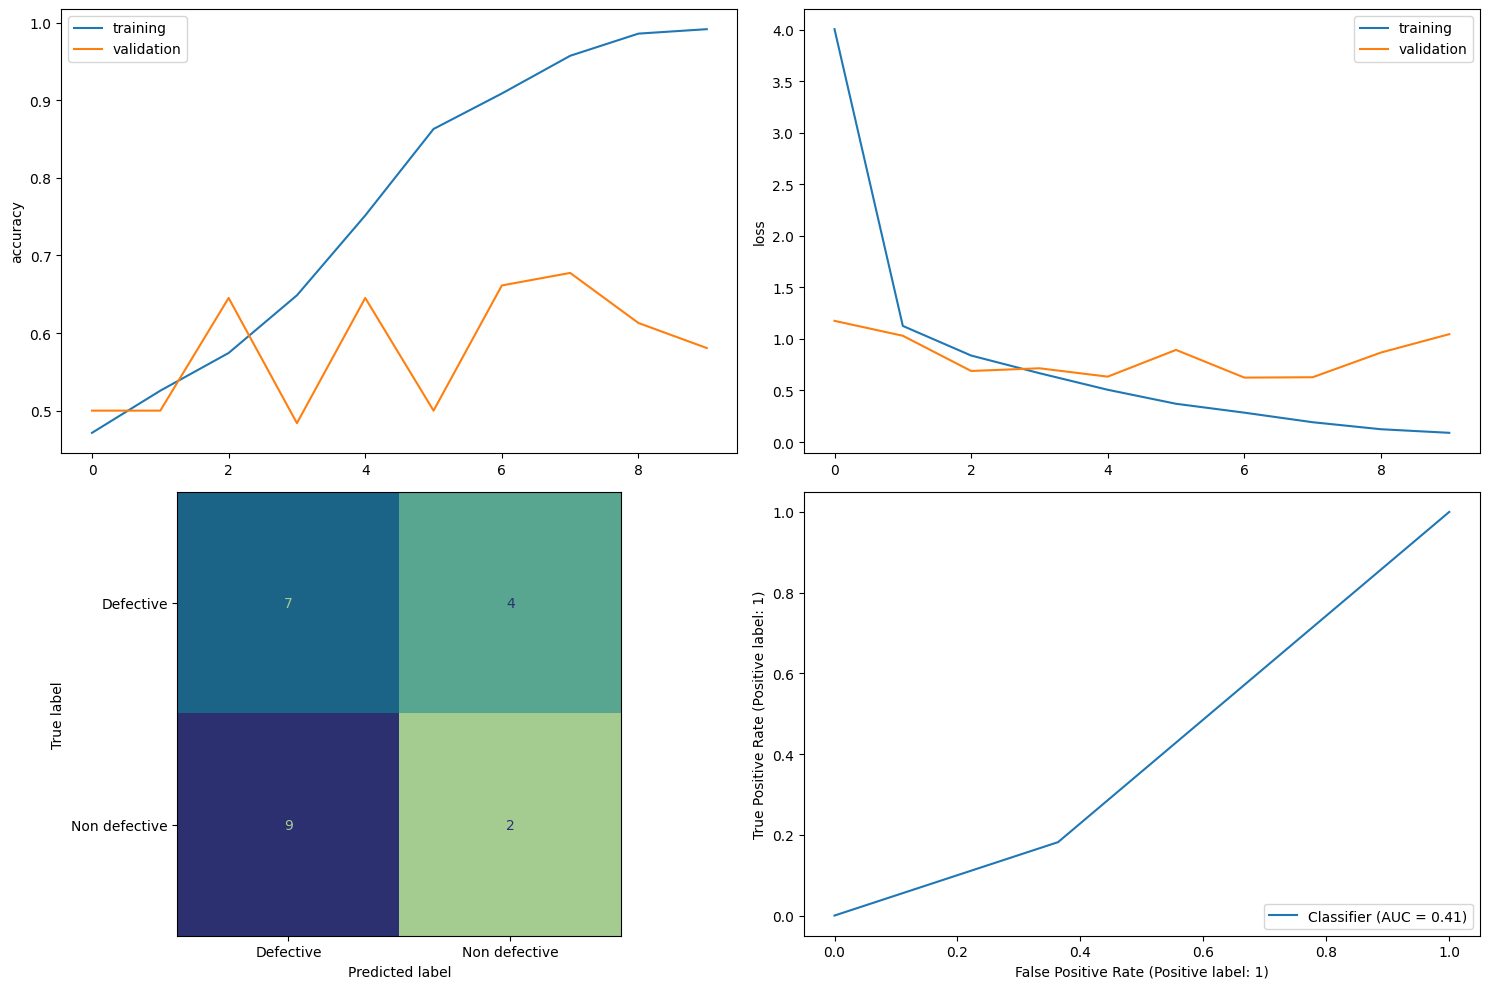

In [15]:
CNN.show_metrics()

## Playground
---
Edge detection

In [ ]:
for sample in random_sample.itertuples():
    obj = ImageProcessor(sample)
    obj.kwargs.update({
        'resize': {
            'height': 256,
            'width': 256
        }
    })
    obj.resize()
    obj.grayscale()
    obj.hist_eq()
    obj.binary()
    obj.noise_filt()
    obj.Laplacian()
    obj.show()
    del obj 


Line detection

In [ ]:
for sample in random_sample.itertuples():
    obj = ImageProcessor(sample)
    obj.resize()
    obj.grayscale()
    obj.Canny()
    obj.Hough()
    obj.show()
    del obj